## Data Loading

In [2]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


## Feature Selection - Experiment 1

### 1-1. Select 8 Features

In [3]:
import numpy as np

def create_features(X1, X2):
    X = []
    for i in range(len(X1)):
        packet_size_direction = sum(X2[i])
        cumulative_packet_size = np.sum([abs(c) for c in X2[i]])
        burst_lengths = len([c for c in X2[i] if c != 0])

        num_incoming_packets = len([c for c in X2[i] if c > 0])
        ratio_incoming_packets = num_incoming_packets / len(X2[i]) if len(X2[i]) > 0 else 0
        num_outgoing_packets = len([c for c in X2[i] if c < 0])
        total_packet_count = len(X2[i])

        feature_vector = [
            packet_size_direction,
            np.mean(X1[i]) if X1[i] else 0,
            cumulative_packet_size,
            burst_lengths,
            num_incoming_packets,
            ratio_incoming_packets,
            num_outgoing_packets,
            total_packet_count
        ]
        X.append(feature_vector)
    return np.array(X)

X = create_features(X1, X2)
y = np.array(y)  

### 1-2. Train, Test and Evaluate

In [4]:
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=2,
    max_depth=35,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

Accuracy: 0.5226
Precision (Weighted): 0.5178
Recall (Weighted): 0.5226
F1 Score (Weighted): 0.5150


## Feature Selection - Experiment 2

### 2-1. Select 24 Features

In [15]:
import numpy as np
from itertools import groupby

# Initialize a list to store the newly created features
features = []

# Calculate each feature
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Ratio of outgoing packets to total packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Ratio of incoming packets to total packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Ratio of incoming packets in the first 30 packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Ratio of incoming packets in the first 30 packets to total packets
    incoming_first_30_all = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in an outgoing burst
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Ratio of outgoing packets in the first 30 packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 10. Ratio of outgoing packets in the first 30 packets to total packets
    outgoing_first_30_all = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 11. Number of packets in the last 5 seconds
    last_5_seconds_packets = len([size for size in size_seq[-5:] if size != 0])
    
    # 12. Standard deviation of packet counts in outgoing bursts
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 13. Average packet count in outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 14. Number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 15. Number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 16. Number of packets in incoming bursts in the first 5 seconds
    incoming_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size < 0)
    
    # 17. Number of packets in outgoing bursts in the first 5 seconds
    outgoing_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size > 0)
    
    # 18. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0
    
    # 19. Ratio of incoming packets in the first 5 packets to total packets
    incoming_first_5 = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 20. Ratio of outgoing packets in the first 5 packets to total packets
    outgoing_first_5 = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0
    
    # 21. Website loading time (total time)
    total_time = sum(time_seq)
    
    # 22. Ratio of incoming packets in the first 5 packets to total packets for incoming packets
    incoming_first_5_all = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 23. Average time interval between packets in the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 24. Ratio of outgoing packets in the first 5 packets to total packets for outgoing packets
    outgoing_first_5_all = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0

    # Append all generated features to the features list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets,
        ratio_outgoing, ratio_incoming, incoming_first_30, incoming_first_30_all,
        burst_outgoing_max, outgoing_first_30, outgoing_first_30_all, last_5_seconds_packets,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts, num_incoming_bursts,
        incoming_burst_first_5_seconds, outgoing_burst_first_5_seconds, incoming_per_second_avg,
        incoming_first_5, outgoing_first_5, total_time, incoming_first_5_all,
        last_5_seconds_time_intervals, outgoing_first_5_all
    ])

# X is the dataset containing 24 features
X = np.array(features)

# y is the labels for each sample
y = np.array(y)

### 2-2. Train, Test and Evaluate

In [16]:
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=2,
    max_depth=35,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

Accuracy: 0.7387
Precision (Weighted): 0.7409
Recall (Weighted): 0.7387
F1 Score (Weighted): 0.7342


## Feature Selection - Experiment 3

### 3-1. Select 32 Features

In [17]:
import numpy as np
from itertools import groupby

# Initialize a list to store all features
features = []

# Feature extraction
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Proportion of outgoing packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Proportion of incoming packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Proportion of incoming packets in the first 30 packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Proportion of outgoing packets in the first 30 packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in outgoing bursts
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Number of packets in the last 5 seconds
    last_5_seconds_packets = len([size for size in size_seq[-5:] if size != 0])
    
    # 10. Standard deviation of outgoing burst sizes
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 11. Average size of outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 12. Number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 13. Number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 14. Number of incoming packets in the first 5 seconds
    incoming_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size < 0)
    
    # 15. Number of outgoing packets in the first 5 seconds
    outgoing_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size > 0)
    
    # 16. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0
    
    # 17. Proportion of incoming packets in the first 5 packets
    incoming_first_5 = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 18. Proportion of outgoing packets in the first 5 packets
    outgoing_first_5 = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0
    
    # 19. Total transmission time
    total_time = sum(time_seq)
    
    # 20. Proportion of incoming packets in the first 5 packets (relative to total incoming packets)
    incoming_first_5_all = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 21. Average time interval in the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 22. Proportion of outgoing packets in the first 5 packets (relative to total outgoing packets)
    outgoing_first_5_all = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0

    # 23. Sum of packet sizes
    sum_packets = sum(size_seq)
    
    # 24. Packets per second
    packets_per_second = len(size_seq) / sum(time_seq) if sum(time_seq) > 0 else 0
    
    # 25. Mean packets per second
    packets_per_second_values = [1 / t for t in time_seq if t > 0]
    mean_packets_per_second = np.mean(packets_per_second_values) if packets_per_second_values else 0
    
    # 26. Standard deviation of packets per second
    std_packets_per_second = np.std(packets_per_second_values) if packets_per_second_values else 0
    
    # 27. Transmission time Q1 (25th percentile)
    transmission_time_Q1 = np.percentile(time_seq, 25) if len(time_seq) > 0 else 0
    
    # 28. Transmission time Q2 (median)
    transmission_time_Q2 = np.percentile(time_seq, 50) if len(time_seq) > 0 else 0
    
    # 29. Transmission time Q3 (75th percentile)
    transmission_time_Q3 = np.percentile(time_seq, 75) if len(time_seq) > 0 else 0
    
    # 30. Transmission time Q4 (maximum)
    transmission_time_Q4 = np.percentile(time_seq, 100) if len(time_seq) > 0 else 0
    
    # 31. Average ordering of outgoing packets
    outgoing_order = [i for i, size in enumerate(size_seq) if size > 0]
    average_outgoing_ordering = np.mean(outgoing_order) if outgoing_order else 0
    
    # 32. Standard deviation of outgoing packet ordering
    std_dev_outgoing_ordering = np.std(outgoing_order) if outgoing_order else 0
    
    # Add all features to the list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets, ratio_outgoing,
        ratio_incoming, incoming_first_30, outgoing_first_30, burst_outgoing_max,
        last_5_seconds_packets, outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts,
        num_incoming_bursts, incoming_burst_first_5_seconds, outgoing_burst_first_5_seconds,
        incoming_per_second_avg, incoming_first_5, outgoing_first_5, total_time,
        incoming_first_5_all, last_5_seconds_time_intervals, outgoing_first_5_all,
        sum_packets, packets_per_second, mean_packets_per_second, std_packets_per_second,
        transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4,
        average_outgoing_ordering, std_dev_outgoing_ordering
    ])

# Convert the feature list to a numpy array
X = np.array(features)

# Labels for each sample
y = np.array(y)


### 3-2. Train, Test and Evaluate

In [18]:
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=2,
    max_depth=35,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

Accuracy: 0.7889
Precision (Weighted): 0.7935
Recall (Weighted): 0.7889
F1 Score (Weighted): 0.7867


## Feature Selection - Experiment 4

### 4-1. Compute Feature Importances

Feature Importance (Top 10):
                      Feature  Importance
30  average_outgoing_ordering    0.067711
31  std_dev_outgoing_ordering    0.062392
1           num_total_packets    0.060027
22                sum_packets    0.056494
0        num_incoming_packets    0.055130
2        num_outgoing_packets    0.054016
15    incoming_per_second_avg    0.049784
3              ratio_outgoing    0.049653
4              ratio_incoming    0.049281
9          outgoing_burst_std    0.048912


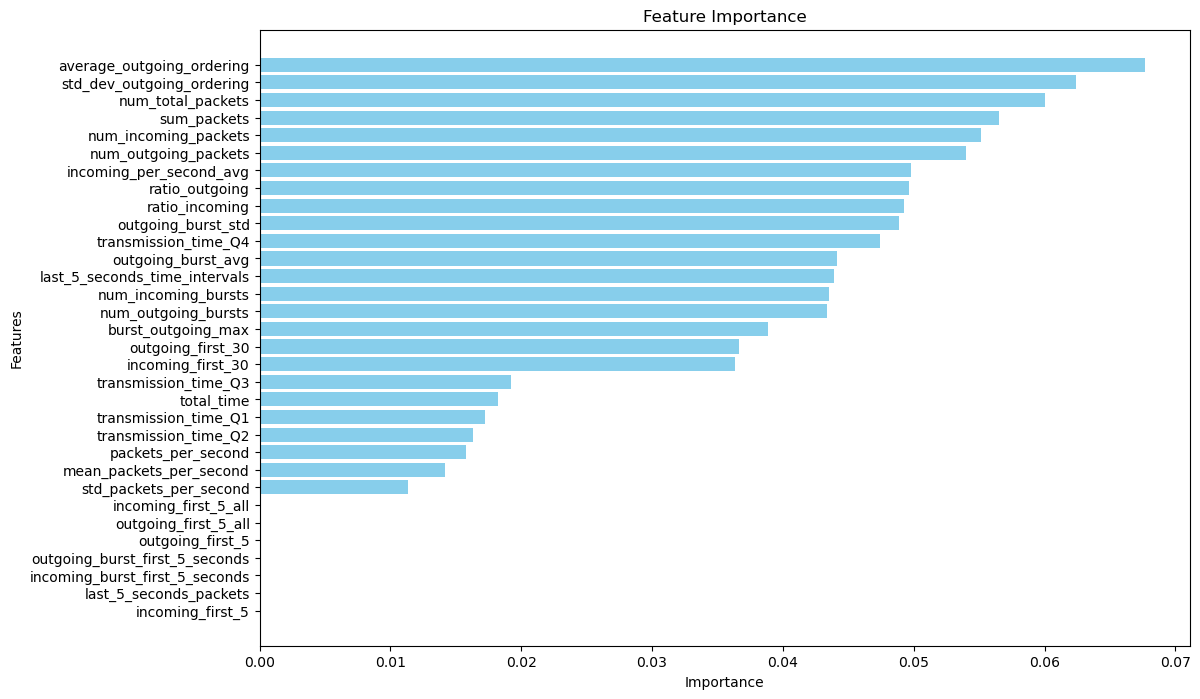

Accuracy: 0.7889
Precision (Weighted): 0.7935
Recall (Weighted): 0.7889
F1 Score (Weighted): 0.7867


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=2,
    max_depth=35,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store the feature names and their importance
feature_names = [
    'num_incoming_packets', 'num_total_packets', 'num_outgoing_packets', 'ratio_outgoing',
    'ratio_incoming', 'incoming_first_30', 'outgoing_first_30', 'burst_outgoing_max',
    'last_5_seconds_packets', 'outgoing_burst_std', 'outgoing_burst_avg', 'num_outgoing_bursts',
    'num_incoming_bursts', 'incoming_burst_first_5_seconds', 'outgoing_burst_first_5_seconds',
    'incoming_per_second_avg', 'incoming_first_5', 'outgoing_first_5', 'total_time',
    'incoming_first_5_all', 'last_5_seconds_time_intervals', 'outgoing_first_5_all',
    'sum_packets', 'packets_per_second', 'mean_packets_per_second', 'std_packets_per_second',
    'transmission_time_Q1', 'transmission_time_Q2', 'transmission_time_Q3', 'transmission_time_Q4',
    'average_outgoing_ordering', 'std_dev_outgoing_ordering'
]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 important features
print("Feature Importance (Top 10):")
print(feature_importance_df.head(10))

# Optionally, plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

# Calculate model performance
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print model performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


### 4-2. Remove unnecessary features and keep only 26 features

In [10]:
import numpy as np
from itertools import groupby

# Initialize a list to store all features
features = []

# Feature extraction
for i in range(len(X2)): 
    size_seq = X2[i-]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Proportion of outgoing packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Proportion of incoming packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Proportion of incoming packets in the first 30 packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Proportion of outgoing packets in the first 30 packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in outgoing bursts
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Standard deviation of outgoing burst sizes
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 10. Average size of outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 11. Number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 12. Number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 13. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0

    # 14. Total transmission time
    total_time = sum(time_seq)

    # 15. Average time interval in the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 16. Sum of packet sizes
    sum_packets = sum(size_seq)
    
    # 17. Packets per second
    packets_per_second = len(size_seq) / sum(time_seq) if sum(time_seq) > 0 else 0
    
    # 18. Mean packets per second
    packets_per_second_values = [1 / t for t in time_seq if t > 0]
    
    # 19. mean of the packets per second values
    mean_packets_per_second = np.mean(packets_per_second_values) if packets_per_second_values else 0
    
    # 20. Standard deviation of packets per second
    std_packets_per_second = np.std(packets_per_second_values) if packets_per_second_values else 0
    
    # 21. Transmission time Q1 (25th percentile)
    transmission_time_Q1 = np.percentile(time_seq, 25) if len(time_seq) > 0 else 0
    
    # 22. Transmission time Q2 (median)
    transmission_time_Q2 = np.percentile(time_seq, 50) if len(time_seq) > 0 else 0
    
    # 23. Transmission time Q3 (75th percentile)
    transmission_time_Q3 = np.percentile(time_seq, 75) if len(time_seq) > 0 else 0
    
    # 24. Transmission time Q4 (maximum)
    transmission_time_Q4 = np.percentile(time_seq, 100) if len(time_seq) > 0 else 0
    
    # 25. Average ordering of outgoing packets
    outgoing_order = [i for i, size in enumerate(size_seq) if size > 0]
    average_outgoing_ordering = np.mean(outgoing_order) if outgoing_order else 0
    
    # 26. Standard deviation of outgoing packet ordering
    std_dev_outgoing_ordering = np.std(outgoing_order) if outgoing_order else 0
    
    # Add all features to the list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets, ratio_outgoing,
        ratio_incoming, incoming_first_30, outgoing_first_30, burst_outgoing_max,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts,
        num_incoming_bursts, incoming_per_second_avg,  total_time,
        last_5_seconds_time_intervals, 
        sum_packets, packets_per_second, mean_packets_per_second, std_packets_per_second,
        transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4,
        average_outgoing_ordering, std_dev_outgoing_ordering
    ])

# Convert the feature list to a numpy array
X = np.array(features)

# Labels for each sample
y = np.array(y)

### 4-3. Train, Test and Evaluate the Final model

In [11]:
from sklearn.metrics import accuracy_score, auc,roc_auc_score, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=2,
    max_depth=35,
    max_features='sqrt',
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

Accuracy: 0.7937
Precision (Weighted): 0.7966
Recall (Weighted): 0.7937
F1 Score (Weighted): 0.7913
